In [36]:
#import sys
#!{sys.executable} -m pip install corner
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import scipy
from scipy import optimize
import scipy.stats as stats
import emcee
import corner

<IPython.core.display.Javascript object>


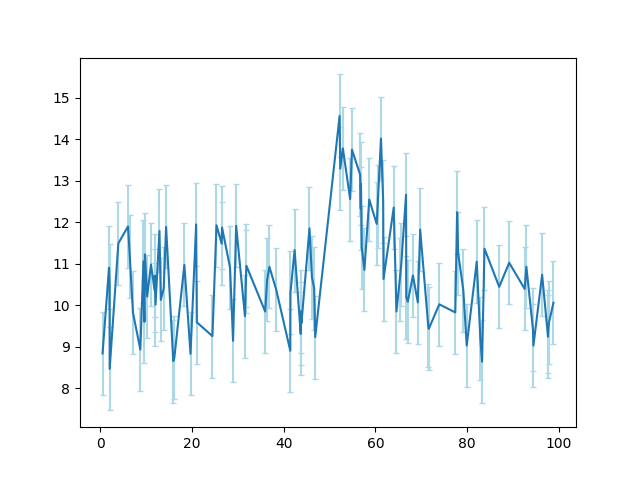

<ErrorbarContainer object of 3 artists>

In [2]:
data = np.load("../solutions/transient.npy", "r")
#print(file[:, 0])
#plt.plot(file[:, 0], file[:, 1])
x = data[:, 0]
y = data[:, 1]
sigma_y = data[:,2]
plt.errorbar(x, y, yerr = sigma_y , xerr=None, ecolor='lightblue', capsize = 2, capthick = 1)

One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.


def model_ (t, t0, b, A, alpha):
    if (t < t0):
        return b
    else:
        return b + A * np.exp(- alpha * (t-t0))

# par = [t0,  b,  A , alpha]


In [3]:
def model_ (t, par):
    modello = []
    for time in t:
        if (time < par[0]):
            modello.append(par[1])              
        else:
            modello.append(par[1] + par[2] * np.exp(- par[3] * (time-par[0])))
    
    return modello

In [4]:
# compute the data log-likelihood given a model
def logL(par, data, model=model_):
    #print( "data dimentions: ", np.shape(data))
    #print("ma vaffanculo mostrami sti data", data)

    """Gaussian log-likelihood of the model """
    x = data [:,0]
    y = data [:,1]
    sigma_y = data [:,2]

    y_fit = model(x, par)
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_par(model=model_, data=data):
    par_0 = [48, 10, 4, 1/20]
    
    neg_logL = lambda par : -logL(par, data, model)
    return scipy.optimize.fmin_bfgs(neg_logL, par_0, disp=False)

we have to write down a likelihood:

gaussian likelihood ---> since central limit theorem etc.

product of probabilities: proportional of the exp

L(


[47.8717214  10.28787809  6.34818037  0.11890551]


<IPython.core.display.Javascript object>


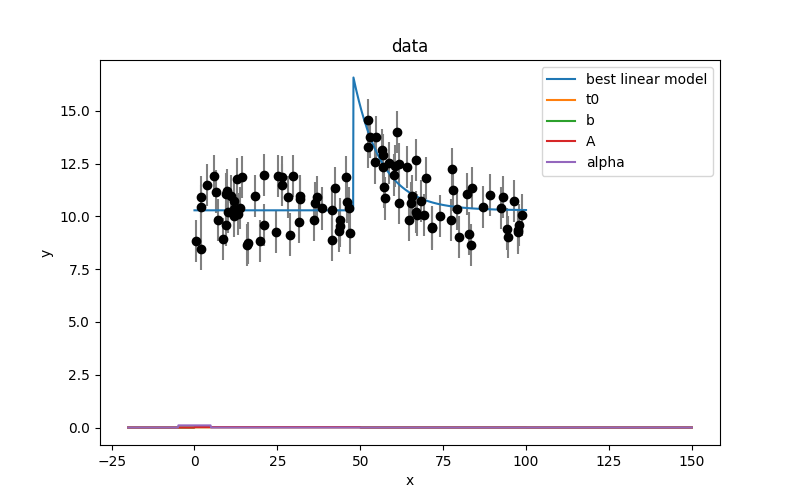

In [5]:
Ndata = x.size

# get best-fit parameters for linear, quadratic and cubic models
par = best_par(model_, data=data)
print(par)

# generate best fit lines on a fine grid 
xgrid = np.linspace(0, 100, 1000)
yfit = model_(xgrid, par)


# plot 
fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xgrid, yfit, label='best linear model')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');


3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 



In [6]:
np.random.seed(21)
Ndata = x.size

## first define the prior, uniform pdf (scherzone questo solo il plot, realtà è più facile)

[[], [], [], []]


<IPython.core.display.Javascript object>


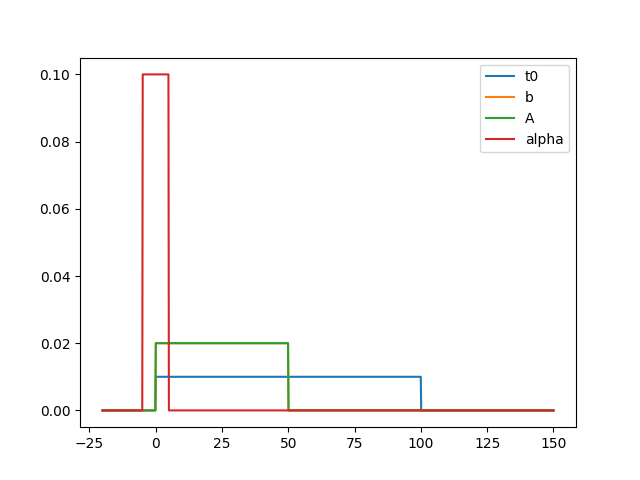

In [8]:
# par = [t0, b, A , alpha]
x_linspace = np.linspace(-20,150, 1000)
par0_mcmc = [[],[],[],[]]
print(par0_mcmc)
def Prior_plot(x):
    for xi in x:
        
        par0_mcmc[0].append(stats.uniform.pdf(xi, loc=0, scale=100))
        par0_mcmc[1].append(stats.uniform.pdf(xi, loc=0, scale=50))
        par0_mcmc[2].append(stats.uniform.pdf(xi, loc=0, scale=50))
        ln_alpha = stats.uniform.pdf(xi, loc=-5, scale=10)
        par0_mcmc[3].append((np.exp(ln_alpha)))
    return par0_mcmc

par0_mcmc = Prior_plot(x_linspace)
    
#plot
plt.plot(x_linspace, par0_mcmc[0], label = 't0' )
plt.plot(x_linspace, par0_mcmc[1], label = 'b' )
plt.plot(x_linspace, par0_mcmc[2], label = 'A' )
plt.plot(x_linspace, np.log(par0_mcmc[3]), label = 'alpha')
plt.legend()
plt.show()

    

# vera definizione della prior

In [9]:
def logPrior(par_mcmc):
    b, A, t0, alpha = par_mcmc
    if 0 < b < 50 and 0 < A < 50 and 0 < t0 < 100 and -5 < np.log(alpha) < 5:
        return 0.0  # log(1) = 0 for valid parameters
    else:
        return -np.inf  # log(0) = -inf for invalid parameters


## we have already defined the likelihood in the previous point of the exercise,
# LET'S GET THE POSTERIOR
(actually the log)

In [10]:
def logPosterior (par_mcmc, data, model = model_):
    return logL(par_mcmc, data, model) + logPrior(par_mcmc)

In [25]:
ndim = 4  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers, It is unadvisable to use a red-blue move with fewer walkers than twice the number of dimensions.
#burn = 10000  # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take **for each walker**
print( "data dimensions: ", np.shape(data))

# initialize the parameters 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, args=(data, ))
#sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)

sampler.run_mcmc(starting_guesses, nsteps, progress = True)
print("done")

data dimensions:  (100, 3)


  0%|          | 1/10000 [00:00<28:02,  5.94it/s]/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
  0%|          | 41/10000 [00:06<26:29,  6.27it/s]/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
  0%|          | 44/10000 [00:07<26:40,  6.22it/s]/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
100%|██████████| 10000/10000 [19:05<00:00,  8.73it/s]

done


(10, 10000, 4)


<IPython.core.display.Javascript object>


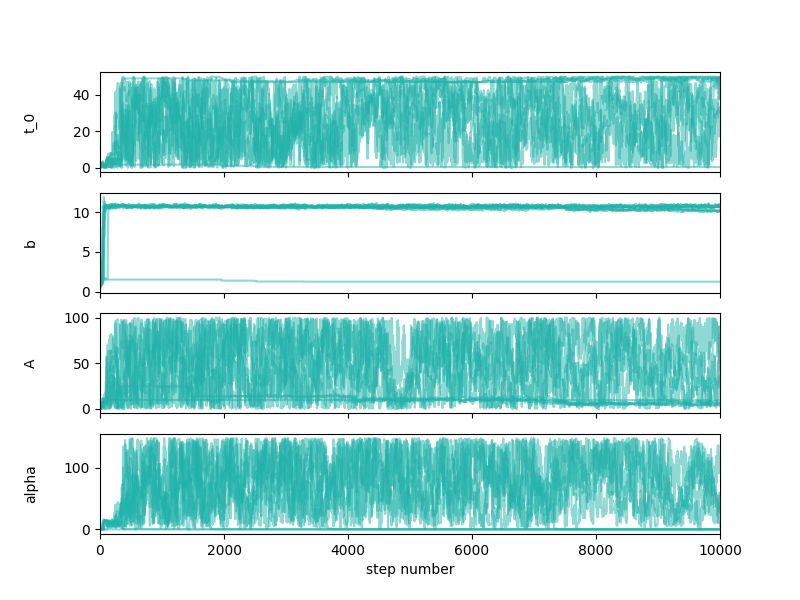

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  


In [28]:
print(sampler.chain.shape) #original chain structure
# sampler.chain is of shape (nwalkers, nsteps, ndim)
fig, axes = plt.subplots(4, figsize=(8, 6), sharex=True)
samples = sampler.get_chain()
labels = ["t_0", "b","A","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.5, color = "lightseagreen")
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

## should add a burn-in period  

(SHOULD I FIRST LOOK AT AUTOCORR LENGTH AND THROW AWAY A COUPLE OF TIMES THAT NUMBER ?? )

In [31]:
burn = 1000  # "burn-in" period to let chains stabilize
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)
print("burned and flattened chain ",emcee_trace.shape) #burned and flattened chain WHERE IS THINNING ? I NEED TO TAKE THE AUTOCORRELATION LENGHT INOTO ACCOUNT
emcee_trace.flatten()
len(emcee_trace.flatten())

burned and flattened chain  (90000, 4)


360000

## still should take autocorrelation length into account ---> thinning

In [32]:
# Now take one point every autocorrelation lenght
tau = sampler.get_autocorr_time()
print(tau, "This suggests that only about", tau[0], " steps are needed for the chain to “forget” where it started. It’s not unreasonable to throw away a few times this number of steps as “burn-in”. Let’s discard the initial 100 steps, thin by about half the autocorrelation time (15 steps), and flatten the chain so that we have a flat list of samples:")

thin = int(tau+1)

emcee_trace = sampler.get_chain(discard=burn, thin=thin, flat=True).flatten()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [751.50852926 237.70821705 591.79942239 469.29540229]

## Now we want to see the plot over data (?) 

## CORNER PLOT

<IPython.core.display.Javascript object>


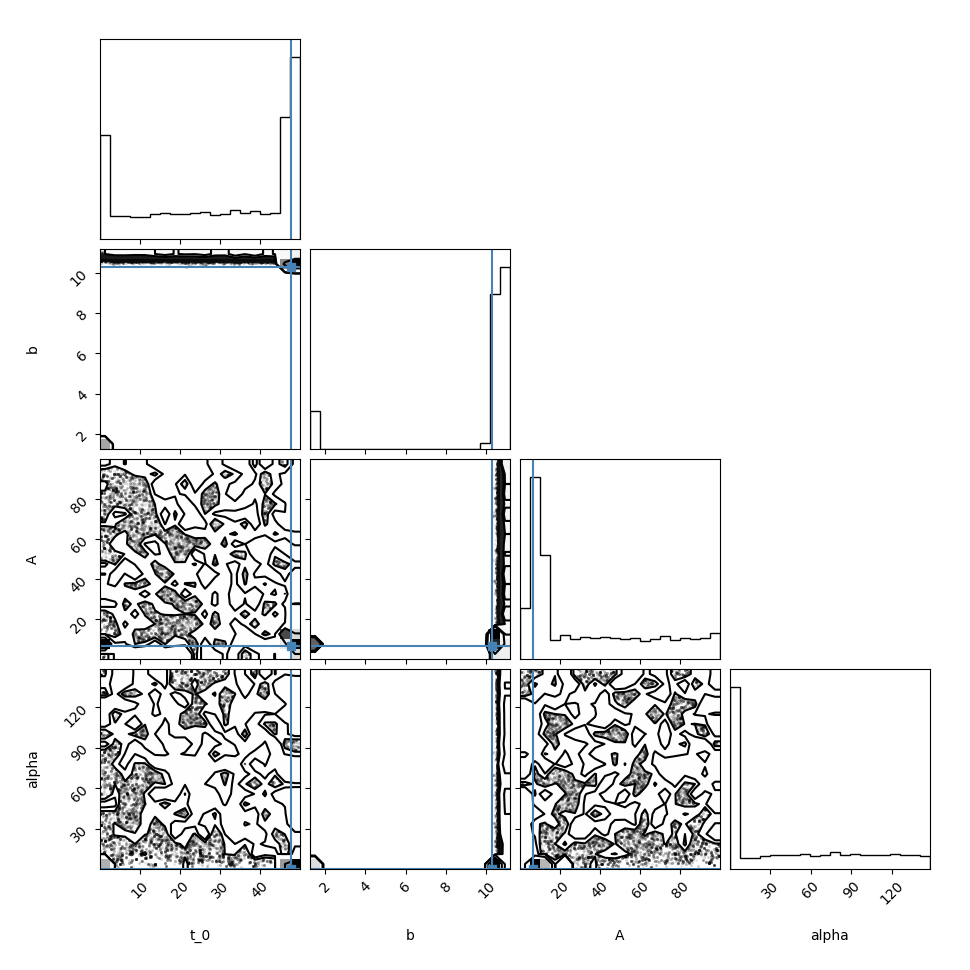

In [39]:
import corner

fig = corner.corner(
#    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
    #I don't have the true values, I can plot the values i got from max likelihood estimation
    emcee_trace, labels=labels, truths=par
);

In [ ]:
# plot 
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(15, 8))
#fig.subplots_adjust(left=0.11, right=0.95, 
                   # wspace=0.35, bottom=0.18)

chainE = emcee_trace #[0]
M = np.size(chainE)

ax1 = fig.add_subplot(121)
xgrid = np.linspace(1, M, M)
plt.plot(xgrid, chainE)
ax1.axis([0, M, np.min(chainE), 1.1*np.max(chainE)])
plt.xlabel('number',fontsize=10)
plt.ylabel('chain',fontsize=10)

# plot running mean: 
meanC = [np.mean(chainE[:int(N)]) for N in xgrid]
ax1.plot(xgrid, meanC, c='red', label='chain mean') 
ax1.plot(xgrid, 0*xgrid + np.mean(data),
         c='yellow',label='data mean')
ax1.legend(fontsize=10)

ax2 = fig.add_subplot(122)
# skip first burn samples
Nburn = 1000
#Nchain = np.size(chainE[xgrid>burn])
Nhist, bins, patches = plt.hist(chainE, 
                                bins='auto', histtype='stepfilled',density=True)

# plot expectations based on central limit theorem
binwidth = bins[1] - bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(0.7, 1.3, 500)
gauss = stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 

ax2.set_ylabel('p(chain)',fontsize=15)
ax2.set_xlabel('chain values',fontsize=15)
#ax2.set_xlim(0.7, 1.3)
#ax2.set_ylim(0, 1.2*np.max(gauss))
ax2.set_title(r'Chain from emcee',fontsize=15)

[1.         1.         1.41520619 1.36394424 1.35993215 1.05399957
 1.00658773 1.00445045 1.00223479 1.00044701 1.00022621 1.0001823
 1.00016491 1.00010059 1.00004373 1.00001985 1.00001897 1.00001638
 1.00000684 1.00000513 1.00000271 1.00000162 1.00000034 1.00000027
 1.00000003 1.00000001 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.

<IPython.core.display.Javascript object>


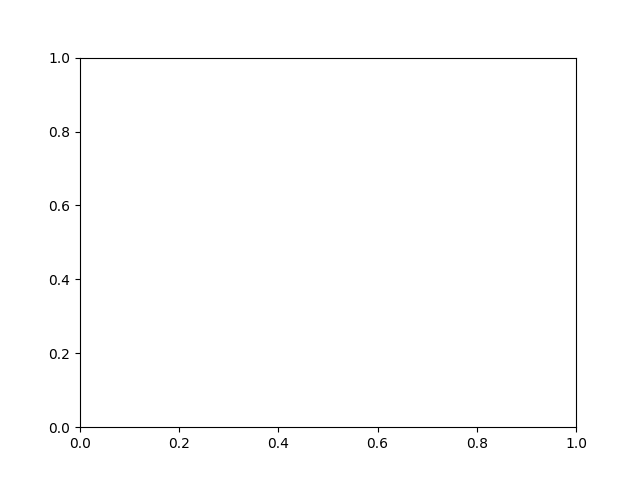

ValueError: x and y must have same first dimension, but have shapes (201,) and (100,)

In [59]:
t0 = 1
b = 1
A = 1
alpha = 1

for t in (file[:, 0]):
    model = np.append(model, model_(t, t0, b, A, alpha))
    
#print(model)

plt.plot(model, file[:,0])

In [ ]:
Likelihood = 